## Configuration and library loading

In [2]:
import os
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/hf_cache"
import pickle
import geopandas as gpd
import torch
from PIL import Image
from tqdm import tqdm
import clip

data_dir = os.path.join("../../../data/embeddings/")

### Load list of sample points

In [3]:
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings.pkl"
with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
print(f"Cache currently has {len(point_records)} points.")

Cache currently has 18897 points.


# Compute the Embeddings

In [74]:
# Define model
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Create text embedding for categories we want to match image embeddings to

- For each headline category, define several different prompts
- Convert each of the subprompts into a text embedding
- For each headling category, find the mean text embedding

In [151]:
multi_prompts = {
    "C – Accommodation": [
        "a photo of a house or home",
        "an apartment building on a street",
        "houses in a residential neighborhood",
        "front view of a suburban house",
        "a cozy home exterior with a garden"],
    "B – Industrial / Storage": [
        "a warehouse or big industrial building",
        "a factory with chimneys or machinery",
        "storage containers outside a building",
        "a logistics yard with trucks and crates",
        "industrial buildings in an urban area"],
    "E – Commercial / Business / Service": [
        "a shop or cafe on the street",
        "a busy high street with stores",
        "a restaurant or small business front",
        "office building in the city",
        "people outside a retail store or service"],
    "F – Local Community / Learning": [
        "a school or university building",
        "library or community centre",
        "children playing at a sports field",
        "outdoor playground or swimming pool",
        "museum, gallery or exhibition space"]}

multi_prompts = {
    "indoor": ["a photo taken indoors",
        "an indoor interior scene",
        "inside a building",
        "an indoor room photo"],
    "terraced house": ["a photo of a terraced house",
        "a row of terraced homes",
        "a UK terrace housing street",
        "a brick terraced house"],
    "semi-detached house": [
        "a photo of a detached or semi detached house",
        "a suburban detached house",
        "a single-family home",
        "a detached house on a residential street"],
    "road": ["a photo of a road",
        "a street with cars or buildings",
        "a roadway scene",
        "a street-level view outdoors"],
    "shop": ["a photo of a shop",
        "a store front",
        "a retail business on a street",
        "a commercial storefront"],
    "car": ["a photo dominated by the outside of a car",
        "a vehicle exterior close-up",
        "a photo of a parked car",
        "a car on the street"],
    "industrial": ["a photo of an industrial building",
        "a warehouse or factory building",
        "an industrial site",
        "a manufacturing facility"],
    "wasteland": ["a photo of wasteland or empty space",
        "an abandoned empty outdoor area",
        "a derelict vacant lot",
        "an unused or empty land area"],
    "greenery": ["a photo of nice green space",
        "a park or garden with trees",
        "green plants and nature",
        "a photo of natural greenery"]}

multi_prompts = {

    # 1. Indoor / interior scenes (to exclude non-street content)
    "indoor": [
        "an indoor photo inside a building",
        "an interior room scene",
        "a photo taken indoors under artificial lighting",
        "inside a residential home",
        "inside an office or workspace",
        "an indoor hallway or corridor",
        "inside a car interior",
        "a room with walls and furniture visible",
        "an indoor photo with no outdoor scenery",
        "an interior living space"
    ],


    # 2. Single residential house (any detached, semi-detached, terraced)
    "single_house": [
        "a single residential house",
        "a standalone house on a street",
        "a terraced or semi-detached home",
        "a suburban residential house",
        "a UK-style house with a front door and windows",
        "a residential house with a garden or driveway",
        "a home with a pitched roof",
        "a brick residential house",
        "a typical British house exterior",
        "a single-family home on a quiet street"
    ],


    # 3. Residential street (multiple houses visible)
    "residential_street": [
        "a residential street with multiple houses",
        "a row of houses along a street",
        "a street lined with terraced homes",
        "a suburban neighbourhood street view",
        "a street with parked cars and houses",
        "a residential road with houses on both sides",
        "a quiet housing neighbourhood",
        "a UK residential area with multiple homes visible",
        "a typical street of British housing",
        "a suburban housing street scene"
    ],


    # 4. Shops and cafes (retail frontage)
    "shops_and_cafes": [
        "a shop or retail storefront",
        "a cafe or coffee shop entrance",
        "a commercial high street with shops",
        "a small business storefront",
        "a row of shops on a street",
        "a trendy cafe or coffee shop",
        "a street with commercial signage",
        "a food takeaway or retail frontage",
        "a boutique store or independent shop",
        "a street with restaurants or cafes"
    ],


    # 5. Road / street without strong residential context
    "road": [
        "a road with cars and traffic",
        "a street with no houses visible",
        "an asphalt road outdoors",
        "a roadway with vehicles",
        "a simple road scene with pavement",
        "a street-level view of a road",
        "a road with buildings far away",
        "a road with painted lane markings",
        "an intersection or junction",
        "a wide street with traffic flow"
    ],


    # 6. Highways / motorways (new category)
    "highway": [
        "a large highway with multiple lanes",
        "a motorway with fast-moving traffic",
        "a dual carriageway",
        "a high-speed road with no houses nearby",
        "a major road with overpasses or slip roads",
        "a highway with barriers and signage",
        "a wide road with multiple lanes of traffic",
        "a motorway with cars travelling at speed",
        "a road with green verges and no buildings",
        "a large transportation corridor"
    ],


    # 7. Car-dominated / close-up vehicles
    "car": [
        "a photo dominated by a car exterior",
        "a close-up of a vehicle",
        "a parked car in the foreground",
        "a photo where a car fills most of the frame",
        "a car on the street close-up",
        "a vehicle photographed from the side",
        "a car front or headlight close-up",
        "a parked vehicle dominating the scene",
        "a photo focused mainly on a car body",
        "a street scene with a car extremely close"
    ],


    # 8. Industrial buildings / warehouses
    "industrial": [
        "an industrial building such as a warehouse",
        "a factory or manufacturing facility",
        "an industrial estate building",
        "a warehouse with metal siding",
        "a large industrial structure",
        "a factory exterior with chimneys",
        "an industrial unit with shutters",
        "a building used for manufacturing or storage",
        "an industrial complex",
        "a photo of a warehouse yard"
    ],


    # 9. Wasteland / derelict land
    "wasteland": [
        "a derelict vacant lot",
        "an empty or abandoned outdoor area",
        "unused land with no buildings",
        "a vacant plot with rubble or overgrowth",
        "an open space with signs of neglect",
        "a barren ground area",
        "an outdoor area with debris and no structures",
        "a neglected or rundown open space",
        "a disused land area",
        "a wasteland with weeds or dirt"
    ],


    # 10. Greenspace / parks
    "greenspace": [
        "a public park with grass and trees",
        "an urban greenspace or recreation area",
        "a landscaped public park",
        "a community park with greenery",
        "a garden or park with plants",
        "a green open space with trees",
        "a park pathway with vegetation",
        "a natural outdoor green area",
        "a public lawn or green field",
        "an urban park with trees and grass"
    ]
}


multi_prompts = {
    "an office": [
        "an office",
        "a collection of offices",
        "an office park",
        "a car park in front of an office building"],
    "a single house": [
        "one house",
        "front of a house",
        "house with door and window"],
    "an urban street": [
        "an urban street"],    
    "shop": [
        "a store front",
        "a retail business on a street",
        "a commercial storefront",
        "a cafe",
        "a closed shop with shutters"],
    "a car": [
        "a car",
        "a parked car",
        "a van",
        " a single vehicle"],
    "a park": [
        "a park"],
    "a cucumber": [
        "a cucumber"],
    "a highway": [
        "a highway"],    
    "a residential street": [
        "a residential street",
        "back of houses on a street",
        "garages on a street",
        "sheds on a street",
        "a road with houses alongside"],    
    "industrial": [
        "an industrial building such as a warehouse",
        "a factory or manufacturing facility",
        "an industrial estate building",
        "a warehouse with metal siding",
        "a large industrial structure",
        "a factory exterior with chimneys",
        "an industrial unit with shutters",
        "a building used for manufacturing or storage",
        "an industrial complex",
        "a photo of a warehouse yard"
    ],
#        "wasteland": [
#         "a derelict vacant lot",
#         "an empty or abandoned outdoor area",
#         "unused land with no buildings",
#         "a vacant plot with rubble or overgrowth",
#         "an open space with signs of neglect",
#         "a barren ground area",
#         "an outdoor area with debris and no structures",
#         "a neglected or rundown open space",
#         "a disused land area",
#         "a wasteland with weeds or dirt"
#     ],
    "a road": [
        "a road with no features",
        "random road",
        "side of road"]}

In [152]:
# List of embeddings for each of the 4 headline categories
final_text_features = []
category_names = []  

# This line tells PyTorch that we're not training CLIP (just using to calculate embeddings), so don't need to compute gradients
# This makes the computation faster
with torch.no_grad():
    # Loop through each category and its list of text prompts
    for cat, prompts in multi_prompts.items():

        # Add the category name to your list (used later for plotting or indexing)
        category_names.append(cat)

        # Convert all textual prompts into CLIP token IDs 
        # Token IDs are numerical codes that represent words or sub-words
        tokenized = clip.tokenize(prompts).to(device)

        # Encode all the token IDs into CLIP text embeddings
        txt_feats = model.encode_text(tokenized)

        # Normalise each prompt embedding to unit length
        # (CLIP uses cosine similarity, so normalisation matters)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)

        # Compute the mean embedding across all prompts for this category
        # This creates a single "category embedding" representing all its prompts
        avg_feat = txt_feats.mean(dim=0)

        # Normalise the averaged embedding again
        # This ensures it remains a proper CLIP embedding for cosine similarity
        avg_feat = avg_feat / avg_feat.norm()

        # Save this averaged category embedding
        final_text_features.append(avg_feat.cpu())

# Convert to tensor of shape (num_categories, 512)
# A tensor is a multi-dimensional array, and is the format expected by PyTorch
final_text_features = torch.stack(final_text_features)
print("Built improved category text embeddings:", final_text_features.shape)

Built improved category text embeddings: torch.Size([11, 512])


## Create embedding for each image and find similarity to categories 
- Create embedding for image
- Find similarity score to text embedding for each category
- Convert similarity score to a "probability-like number" using softmax

In [156]:
def embed_and_score_clip(image_path):
    """
    Loads an image, computes its CLIP embedding, 
    and calculates similarity-based category probabilities.

    Returns:
        image_embedding (np.array): 512-dim CLIP image embedding
        category_probabilities (np.array): Probability for each category
    """

    # -----------------------------------------------------------
    # 1. LOAD AND PREPROCESS THE IMAGE
    # -----------------------------------------------------------
    # Load image using PIL and convert to 3-channel RGB
    pil_image = Image.open(image_path).convert("RGB")

    # Apply CLIP preprocessing:
    # - resize/crop to 224x224
    # - convert to torch tensor
    # - normalise pixels with CLIP’s mean/std
    # This produces a tensor of shape (3, 224, 224)
    image_tensor = preprocess(pil_image)

    # Add a batch dimension → (1, 3, 224, 224)
    # Required because CLIP expects a batch
    image_tensor = image_tensor.unsqueeze(0)

    # Move tensor to CPU or GPU depending on device
    image_tensor = image_tensor.to(device)

    # -----------------------------------------------------------
    # 2. RUN CLIP TO GET IMAGE EMBEDDING
    # -----------------------------------------------------------
    # Disable gradient tracking 
    with torch.no_grad():

        # Encode the image → produces a 512-dim CLIP embedding
        raw_image_embedding = model.encode_image(image_tensor)

        # Normalise embedding to unit length (important for cosine similarity)
        image_embedding = raw_image_embedding / raw_image_embedding.norm(
            dim=-1, keepdim=True)

        # -----------------------------------------------------------
        # 3. COMPUTE SIMILARITIES TO TEXT CATEGORY EMBEDDINGS
        # -----------------------------------------------------------
        # Returns similarity of the 1 image embedding to N text embeddings
        # These are dot products, representing how close the image is to each category in embedding space
        similarity_scores = (image_embedding @ final_text_features.to(device).T)

        ######## Convert raw similarities to probabilities
        # Softmax is a function that turns a set of numbers into a probability-like distribution
        # However, the numbers do not represent true probabilities
        # e.g. Scores of Indoor: 0.75, Greenery: 0.18, Terraced house: 0.04, Road: 0.02, Shop: 0.01
        # Mean that The "indoor" text embedding was much closer to the image embedding than the others.
        # And NOT that the true probability that the scene is indoors is 75%.
        category_probabilities = similarity_scores.softmax(dim=-1)

    # -----------------------------------------------------------
    # 4. RETURN CLEAN CPU NUMPY ARRAYS
    # -----------------------------------------------------------
    return (
        image_embedding.cpu().numpy()[0],       # shape (512,)
        similarity_scores.cpu().numpy()[0],
        category_probabilities.cpu().numpy()[0] # shape (num_categories,)
    )

# ------------------------------
# 5. Embed all images
# ------------------------------
for rec in tqdm(point_records, desc="Embedding points", unit="point"):
# for rec in point_records[200:300]:    

    rec["embedding"] = []
    rec["category_scores"] = []
    rec["category_probs"] = []
    
    for img_path in rec["image_files"]:

        # Use ORIGINAL images
        img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../../")

        try:
            embedding, scores, probabilities = embed_and_score_clip(img_path)
            
            rec["embedding"].append(embedding)
            rec["category_scores"].append(scores)
            rec["category_probs"].append(probabilities)
            
            # Testing
#             img = Image.open(img_path)
#             fig,ax=plt.subplots(figsize=(2,2))
#             ax.axis("off")
#             plt.imshow(img)
#             plt.show()
#             argmax = scores.argmax()
#             print(list(multi_prompts.keys())[argmax])
            
        except Exception as e:
            tqdm.write(f"⚠️ Error: {e}")

Embedding points:  48%|███████████████████████████████████████████████████▊                                                       | 9159/18897 [24:05<23:03,  7.04point/s]

⚠️ Error: [Errno 2] No such file or directory: '../../../data/embeddings/street_images/point9285_heading90.jpg'


Embedding points:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 18666/18897 [49:35<00:41,  5.58point/s]

⚠️ Error: [Errno 2] No such file or directory: '../../../data/embeddings/street_images/point18959_heading270.jpg'


Embedding points: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 18897/18897 [50:14<00:00,  6.27point/s]


## Save outputs to pickle file

In [158]:
output_file = (data_dir + "sample_points_cache/points_data_cache_with_CLIP_embeddings_and_scores_refined_again.pkl")

with open(output_file, "wb") as f:
    pickle.dump(point_records, f)

print(f"\n💾 Saved embeddings + category scores for {len(point_records)} points.")


💾 Saved embeddings + category scores for 18897 points.


## Testing

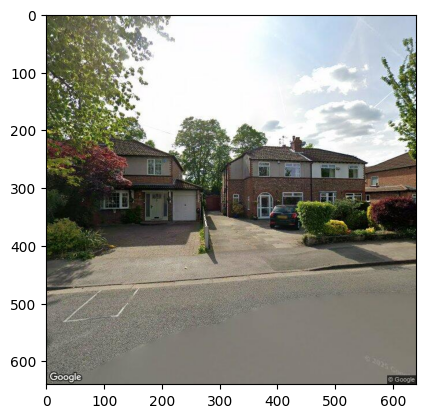

In [62]:
import matplotlib.pyplot as plt
img_path = point_records[2]["image_files"][3]
img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../../")
img = Image.open(img_path)
plt.imshow(img)

In [39]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

#Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

In [70]:
#Encode text descriptions
text_emb = model.encode(['Two dogs in the snow', "a pizza", 'A cat on a table', 'A picture of a road, with cars and trees'])
text_emb = model.encode(["a cucumber", "semi-detached house", "a highway with few cars and grass embankments", "a car", "a view down a road", "a park"])

In [71]:
#Encode an image:
img_emb = model.encode(Image.open(img_path))

#Compute cosine similarities 
cos_scores = util.cos_sim(img_emb, text_emb)
print(cos_scores)

tensor([[0.1703, 0.2498, 0.1473, 0.1782, 0.1726, 0.1844]])


In [68]:
text_emb = model.encode(["a house", "a shop", "a car", "a road", "a park"])

#Compute cosine similarities 
cos_scores = util.cos_sim(img_emb, text_emb)
print(cos_scores)

tensor([[0.2154, 0.1758, 0.1782, 0.1853, 0.1844]])
